# Topic Modelling

Topic modelling was conducted on the following datasets for this file:
- Pre-Covid dataset
- Covid dataset

The code for topic modelling was taken from: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

In [37]:
#install dependencies if you don't have them
# !pip install spacy
# !python3 -m spacy download en_core_web_sm
# !pip install gensim
# !pip install pyLDAvis
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

In [1]:
#import statements for libraries
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'gensim'

In [8]:
#import statements for different datasets
#import all years individually
df2017 = pd.read_csv ('../datasets/CleanData/2017_cleaned_songs_lyrics.csv')
df2018 = pd.read_csv ('../datasets/CleanData/2018_cleaned_songs_lyrics.csv')
df2019 = pd.read_csv ('../datasets/CleanData/2019_cleaned_songs_lyrics.csv')
df2020 = pd.read_csv ('../datasets/CleanData/2020_cleaned_songs_lyrics.csv')
df2021 = pd.read_csv ('../datasets/CleanData/2021_cleaned_songs_lyrics.csv')


#create pre-covid and covid datasets
df2017['Year'] = 2017
df2018['Year'] = 2018
df2019['Year'] = 2019
df2020['Year'] = 2020
df2021['Year'] = 2021

df_precov = pd.concat([df2017, df2018, df2019])
df_cov = pd.concat([df2020, df2021])

In [9]:
df_precov.head()

,Unnamed: 0,track_name,artist,streams,uid,cleaned_lyrics,stemmed_lyrics,lemmatized_lyrics,Year
0,0,Shape of You,Ed Sheeran,1514648943,7qiZfU4dY1lWllzX7mPBI3,club best place find lover bar go friends tabl...,club best place find lover bar go friend tabl ...,club best place find lover bar go friend table...,2017
1,1,Something Just Like This,"The Chainsmokers, Coldplay",704250265,6RUKPb4LETWmmr3iAEQktW,reading books old legends myths achilles gold ...,read book old legend myth achil gold hercul gi...,reading book old legend myth achilles gold her...,2017
2,2,HUMBLE.,Kendrick Lamar,665416406,7KXjTSCq5nL1LoYtL7XAwS,nobody pray day way yeah yeah ayy remember syr...,nobodi pray day way yeah yeah ayi rememb syrup...,nobody pray day way yeah yeah ayy remember syr...,2017
3,3,"I'm the One (feat. Justin Bieber, Quavo, Chanc...","DJ Khaled, Justin Bieber, Quavo, Chance the Ra...",649357383,3DXncPQOG4VBw3QHh3S817,best music another one dj khaled yeah lookin t...,best music anoth one dj khale yeah lookin trut...,best music another one dj khaled yeah lookin t...,2017
4,4,It Ain't Me (with Selena Gomez),"Kygo, Selena Gomez",613063656,3eR23VReFzcdmS7TYCrhCe,dream sipping whiskey neat highest floor bower...,dream sip whiskey neat highest floor boweri hi...,dream sipping whiskey neat highest floor bower...,2017


In [4]:
#check the datasets
# df_precov.head()
df_cov.head()
# df_precov.tail()
# df_cov.tail()

,Unnamed: 0,track_name,artist,streams,uid,cleaned_lyrics,stemmed_lyrics,lemmatized_lyrics,Year
0,0,Blinding Lights,The Weeknd,1236759169,0VjIjW4GlUZAMYd2vXMi3b,yeah tryna call long enough maybe show love ma...,yeah tryna call long enough mayb show love may...,yeah tryna call long enough maybe show love ma...,2020
1,1,Dance Monkey,Tones And I,1194341955,1rgnBhdG2JDFTbYkYRZAku,say oh god see way shine take hands dear place...,say oh god see way shine take hand dear place ...,say oh god see way shine take hand dear place ...,2020
2,2,The Box,Roddy Ricch,1045663988,0nbXyq5TXYPCO7pr3N8S4I,pullin coupe lot told em fuck fuck swat bustin...,pullin coup lot told em fuck fuck swat bustin ...,pullin coupe lot told em fuck fuck swat bustin...,2020
3,3,ROCKSTAR (feat. Roddy Ricch),"DaBaby, Roddy Ricch",917851312,7ytR5pFWmSjzHJIeQkgog4,woo woo pull like pull baby pull oh oh oh pull...,woo woo pull like pull babi pull oh oh oh pull...,woo woo pull like pull baby pull oh oh oh pull...,2020
4,4,Watermelon Sugar,Harry Styles,852045823,6UelLqGlWMcVH1E5c4H7lY,tastes like strawberries summer evenin sounds ...,tast like strawberri summer evenin sound like ...,taste like strawberry summer evenin sound like...,2020


In [5]:
#check the datasets
df_precov.shape

(2732, 9)

In [6]:
#check the datasets
df_cov.shape

(1734, 9)

In [8]:
#creating lists from lemmatized lyrics
dataprecov = df_precov.lemmatized_lyrics.tolist()
datacov = df_cov.lemmatized_lyrics.tolist()


#function sent_to_words changes sentencce into lists made of list of words
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

datawordsprecov = list(sent_to_words(dataprecov))
datawordscov = list(sent_to_words(datacov))

# Code for Pre-Covid Data

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(datawordsprecov, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[datawordsprecov], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[datawordsprecov][0]])

['club', 'best', 'place', 'find', 'lover', 'bar', 'go', 'friend', 'table', 'shot', 'drinking', 'fast', 'talk', 'slow', 'come', 'start', 'conversation', 'trust', 'give', 'chance', 'take', 'hand', 'stop', 'put', 'van', 'man', 'jukebox', 'start', 'dance', 'singing', 'like', 'girl', 'know', 'want', 'love', 'love', 'handmade_somebody', 'like', 'come', 'follow_lead', 'may', 'crazy', 'mind', 'say', 'boy', 'let', 'talk', 'much', 'grab_waist', 'put', 'body', 'come', 'follow_lead', 'come', 'come', 'follow_lead', 'love', 'shape_push', 'pull', 'like', 'magnet_although_heart', 'falling', 'love', 'body', 'last', 'night', 'room', 'bed', 'sheet_smell', 'like', 'every', 'day', 'discovering_something', 'brand_new', 'love', 'body', 'oh', 'oh', 'oh', 'oh', 'love', 'body', 'oh', 'oh', 'oh', 'oh', 'love', 'body', 'oh', 'oh', 'oh', 'oh', 'love', 'body', 'every', 'day', 'discovering_something', 'brand_new', 'love', 'shape', 'one', 'week', 'let', 'story', 'begin', 'going', 'first', 'date', 'thrifty', 'go', 'ea

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [11]:
# Form Bigrams
data_words_bigrams = make_bigrams(datawordsprecov)

In [12]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])
#read corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 14), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 17), (8, 2), (9, 6), (10, 1), (11, 1), (12, 37), (13, 1), (14, 2), (15, 1), (16, 1), (17, 6), (18, 6), (19, 1), (20, 1), (21, 1), (22, 6), (23, 3), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 6), (30, 1), (31, 1), (32, 2), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 2), (39, 3), (40, 2), (41, 1), (42, 1), (43, 2), (44, 3), (45, 1), (46, 3), (47, 10), (48, 25), (49, 1), (50, 3), (51, 1), (52, 1), (53, 2), (54, 2), (55, 2), (56, 3), (57, 24), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 3), (64, 3), (65, 1), (66, 3), (67, 2), (68, 3), (69, 3), (70, 3), (71, 1), (72, 2), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 4), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1)]]


[[('baby', 14),
  ('backseat', 1),
  ('bag', 1),
  ('bar', 1),
  ('bed', 3),
  ('begin', 1),
  ('best', 1),
  ('body', 17),
  ('boy', 2),
  ('brand_new', 6),
  ('chance', 1),
  ('club', 1),
  ('come', 37),
  ('conversation', 1),
  ('crazy', 2),
  ('dance', 1),
  ('date', 1),
  ('day', 6),
  ('discovering_something', 6),
  ('drinking', 1),
  ('driver', 1),
  ('eat', 1),
  ('every', 6),
  ('falling', 3),
  ('family', 1),
  ('fast', 1),
  ('fill', 2),
  ('find', 1),
  ('first', 1),
  ('follow_lead', 6),
  ('friend', 1),
  ('get', 1),
  ('girl', 2),
  ('give', 1),
  ('go', 2),
  ('going', 1),
  ('grab_waist', 2),
  ('hand', 1),
  ('handmade_somebody', 2),
  ('heart', 3),
  ('hour', 2),
  ('jukebox', 1),
  ('kiss', 1),
  ('know', 2),
  ('last', 3),
  ('leave', 1),
  ('let', 3),
  ('like', 10),
  ('love', 25),
  ('lover', 1),
  ('magnet_although', 3),
  ('make', 1),
  ('man', 1),
  ('may', 2),
  ('mind', 2),
  ('much', 2),
  ('night', 3),
  ('oh', 24),
  ('okay', 1),
  ('one', 1),
  ('place'

### Finding optimal number of topics for PreCov
Code acquired from and credited to: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

In [13]:
# coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus,texts = data_words, coherence='u_mass')
# coherence = coherence_model.get_coherence()

def compute_coherence_values(corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, texts = texts, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
model_list, coherence_values = compute_coherence_values(corpus=corpus, texts=datawordsprecov, start=1, limit=18, step=1)

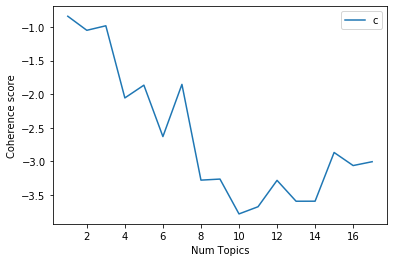

In [15]:
# Show graph
limit=18; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of -0.8412
Num Topics = 2  has Coherence Value of -1.0503
Num Topics = 3  has Coherence Value of -0.983
Num Topics = 4  has Coherence Value of -2.056
Num Topics = 5  has Coherence Value of -1.8663
Num Topics = 6  has Coherence Value of -2.6308
Num Topics = 7  has Coherence Value of -1.8546
Num Topics = 8  has Coherence Value of -3.2786
Num Topics = 9  has Coherence Value of -3.2628
Num Topics = 10  has Coherence Value of -3.7811
Num Topics = 11  has Coherence Value of -3.6745
Num Topics = 12  has Coherence Value of -3.282
Num Topics = 13  has Coherence Value of -3.5924
Num Topics = 14  has Coherence Value of -3.5919
Num Topics = 15  has Coherence Value of -2.8673
Num Topics = 16  has Coherence Value of -3.0618
Num Topics = 17  has Coherence Value of -3.0046


In [17]:
print("Hence, optimal value is Num Topics = 10")

Hence, optimal value is Num Topics = 10


### Running Topic Modelling with Optimal Number of Topics for PreCov

In [18]:
#topic model for 2017 data
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.043*"nigga" + 0.030*"bitch" + 0.027*"got" + 0.020*"woo" + 0.019*"like" + 0.019*"yeah" + 0.019*"uh" + 0.016*"get" + 0.011*"go" + 0.011*"pop"'), (1, '0.039*"shit" + 0.027*"got" + 0.027*"nigga" + 0.018*"gon" + 0.012*"like" + 0.012*"god" + 0.011*"man" + 0.011*"see" + 0.010*"real" + 0.010*"get"'), (2, '0.066*"oh" + 0.041*"love" + 0.018*"one" + 0.017*"day" + 0.016*"come" + 0.012*"heart" + 0.011*"christmas" + 0.011*"baby" + 0.010*"thing" + 0.009*"home"'), (3, '0.159*"la" + 0.018*"bounce" + 0.016*"work" + 0.015*"eh" + 0.014*"go" + 0.014*"like" + 0.014*"woman" + 0.013*"loco" + 0.012*"let" + 0.011*"que"'), (4, '0.054*"ayy" + 0.052*"fuck" + 0.048*"like" + 0.025*"bitch" + 0.019*"back" + 0.016*"got" + 0.015*"huh" + 0.012*"fuckin" + 0.011*"get" + 0.011*"made"'), (5, '0.243*"woah" + 0.044*"surf_surf" + 0.033*"slatt" + 0.020*"mm_mm" + 0.016*"doo_doo" + 0.016*"dreaming" + 0.015*"thunder_thunder" + 0.015*"demon" + 0.011*"ohh" + 0.009*"feel"'), (6, '0.041*"take" + 0.028*"lord" + 0.027*"power" + 0

In [20]:
# Perplexity
perplexity = lda_model.log_perplexity(corpus)
# Coherence
coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus, 
                                                              texts = datawordsprecov, coherence='u_mass')
coherence = coherence_model.get_coherence()
print(perplexity, coherence)

-7.61202193816685 -3.781054502092141


### Visualising outcomes of PreCov data

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Djulian\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\Djulian\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Djulian\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.159147  0.177373       1        1  25.572801
2     -0.098027  0.242633       2        1  17.439113
8     -0.170246  0.091091       3        1  14.762039
0     -0.149274 -0.222368       4        1  13.437047
1     -0.139642 -0.172902       5        1  11.230218
4     -0.166846 -0.119018       6        1  10.117474
3      0.178884  0.068309       7        1   2.789111
7      0.184468  0.064577       8        1   2.517811
6      0.249937 -0.059969       9        1   1.485302
5      0.269893 -0.069726      10        1   0.649084, topic_info=          Term          Freq         Total Category  logprob  loglift
248       yeah  15123.000000  15123.000000  Default  30.0000  30.0000
195        ooh   5555.000000   5555.000000  Default  29.0000  29.0000
57          oh   7817.000000   7817.000000  Default  28.0000  28.0000
528         la   2593.000000   2593.000000  Default  27.0000  27.0000
135        ayy   3183.000000   3183.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
644       feel     32.716906   2908.559502  Topic10  -4.7528   0.5498
117  something     21.539919    670.643801  Topic10  -5.1708   1.5990
33        give     19.528856   1847.622295  Topic10  -5.2688   0.4876
325      never     19.082694   3385.448972  Topic10  -5.2919  -0.1411
57          oh     16.885517   7817.956896  Topic10  -5.4142  -1.1004

[630 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
88       10  0.902634  achilles
616       1  0.994894     admit
1015      1  0.994758    afraid
886       3  0.062000        ah
886       6  0.016047        ah
...     ...       ...       ...
615       4  0.235041     young
615       5  0.071059     young
615       8  0.010932     young
615      10  0.005466     young
3676      6  0.993150   youngin

[1170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 9, 1, 2, 5, 4, 8, 7, 6])

# Code for Covid Dataset

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(datawordscov, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[datawordscov], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[datawordscov][0]])

['yeah', 'tryna', 'call', 'long', 'enough', 'maybe', 'show', 'love', 'maybe', 'going', 'withdrawal', 'even', 'much', 'turn', 'touch', 'baby', 'look', 'around', 'sin', 'city', 'cold', 'empty', 'oh', 'one', 'around', 'judge', 'oh', 'see', 'clearly', 'gone', 'said', 'ooh', 'blinded_light_sleep', 'feel', 'touch', 'said', 'ooh', 'drowning', 'night', 'oh', 'like', 'one', 'trust', 'hey', 'hey', 'hey', 'running', 'time', 'cause', 'see', 'sun', 'light', 'sky', 'hit', 'road', 'overdrive', 'baby', 'oh', 'city', 'cold', 'empty', 'oh', 'one', 'around', 'judge', 'oh', 'see', 'clearly', 'gone', 'said', 'ooh', 'blinded_light_sleep', 'feel', 'touch', 'said', 'ooh', 'drowning', 'night', 'oh', 'like', 'one', 'trust', 'calling', 'back', 'let', 'know', 'back', 'let', 'know', 'could', 'never', 'say', 'phone', 'say', 'phone', 'never', 'let', 'go', 'time', 'ooh', 'said', 'ooh', 'blinded_light_sleep', 'feel', 'touch', 'hey', 'hey', 'hey', 'hey', 'hey', 'hey', 'said', 'ooh', 'blinded_light_sleep', 'feel', 'touc

In [23]:
# Form Bigrams
data_words_bigrams = make_bigrams(datawordscov)

In [24]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])
#read corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 3), (1, 2), (2, 2), (3, 4), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 4), (16, 1), (17, 1), (18, 2), (19, 9), (20, 1), (21, 2), (22, 2), (23, 3), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 2), (33, 7), (34, 4), (35, 7), (36, 1), (37, 2), (38, 1), (39, 1), (40, 6), (41, 2), (42, 3), (43, 1), (44, 1), (45, 1), (46, 4), (47, 1), (48, 2), (49, 5), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1)]]


[[('around', 3),
  ('baby', 2),
  ('back', 2),
  ('blinded_light', 4),
  ('call', 1),
  ('calling', 1),
  ('cause', 1),
  ('city', 2),
  ('clearly', 2),
  ('cold', 2),
  ('could', 1),
  ('drowning', 2),
  ('empty', 2),
  ('enough', 1),
  ('even', 1),
  ('feel', 4),
  ('go', 1),
  ('going', 1),
  ('gone', 2),
  ('hey', 9),
  ('hit', 1),
  ('judge', 2),
  ('know', 2),
  ('let', 3),
  ('light', 1),
  ('like', 2),
  ('long', 1),
  ('look', 1),
  ('love', 1),
  ('maybe', 2),
  ('much', 1),
  ('never', 2),
  ('night', 2),
  ('oh', 7),
  ('one', 4),
  ('ooh', 7),
  ('overdrive', 1),
  ('phone', 2),
  ('road', 1),
  ('running', 1),
  ('said', 6),
  ('say', 2),
  ('see', 3),
  ('show', 1),
  ('sin', 1),
  ('sky', 1),
  ('sleep', 4),
  ('sun', 1),
  ('time', 2),
  ('touch', 5),
  ('trust', 2),
  ('tryna', 1),
  ('turn', 1),
  ('withdrawal', 1),
  ('yeah', 1)]]

### Finding optimal number of topics for Covid
Code acquired from and credited to: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

In [25]:
model_list, coherence_values = compute_coherence_values(corpus=corpus, texts=datawordscov, start=6, limit=18, step=1)

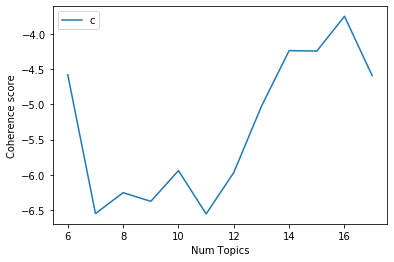

In [26]:
# Show graph
limit=18; start=6; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of -4.5784
Num Topics = 7  has Coherence Value of -6.5499
Num Topics = 8  has Coherence Value of -6.253
Num Topics = 9  has Coherence Value of -6.3762
Num Topics = 10  has Coherence Value of -5.9393
Num Topics = 11  has Coherence Value of -6.5545
Num Topics = 12  has Coherence Value of -5.9665
Num Topics = 13  has Coherence Value of -5.0258
Num Topics = 14  has Coherence Value of -4.2359
Num Topics = 15  has Coherence Value of -4.2431
Num Topics = 16  has Coherence Value of -3.7483
Num Topics = 17  has Coherence Value of -4.5914


In [28]:
print("Hence, optimal value is Num Topics = 11")

Hence, optimal value is Num Topics = 11


### Running Topic Modelling with Optimal Number of Topics for Covid

In [29]:
#topic model for 2017 data
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.072*"ride" + 0.059*"turn" + 0.026*"highway_hell" + 0.020*"raised" + 0.014*"wheel" + 0.013*"giddy_yap" + 0.012*"know" + 0.011*"ring_ling" + 0.008*"order" + 0.008*"tell"'), (1, '0.084*"mm_mm" + 0.022*"mmh_mmh" + 0.021*"seven_summer" + 0.021*"ago" + 0.020*"baow" + 0.019*"mm" + 0.019*"hmm" + 0.013*"golden" + 0.013*"thriller" + 0.011*"hero"'), (2, '0.042*"like" + 0.021*"call" + 0.021*"never" + 0.019*"think" + 0.018*"back" + 0.017*"cause" + 0.010*"man" + 0.009*"everybody" + 0.008*"talk" + 0.008*"heartless"'), (3, '0.032*"baby" + 0.025*"run" + 0.024*"tonight" + 0.024*"like" + 0.023*"come" + 0.017*"night" + 0.015*"na_na" + 0.014*"christmas" + 0.013*"mmm" + 0.012*"kiss"'), (4, '0.045*"high" + 0.036*"let" + 0.030*"low" + 0.019*"dreaming" + 0.017*"telling" + 0.012*"patient" + 0.012*"come" + 0.011*"light" + 0.009*"running" + 0.009*"di"'), (5, '0.198*"la" + 0.022*"prove" + 0.015*"warnin" + 0.015*"body" + 0.014*"ting" + 0.011*"lo" + 0.011*"mi" + 0.010*"ah" + 0.010*"sexy" + 0.009*"kiss"'), (6

In [31]:
# Perplexity
perplexity = lda_model.log_perplexity(corpus)
# Coherence
coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus, 
                                                              texts = datawordscov, coherence='u_mass')
coherence = coherence_model.get_coherence()
print(perplexity, coherence)

-7.90619845539715 -6.554526410580411


### Visualising outcomes of Covid Data

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Djulian\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\Djulian\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Djulian\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.258589  0.026367       1        1  34.888086
8     -0.191270  0.148991       2        1  27.817621
2     -0.155733  0.176748       3        1   9.203194
3     -0.134816 -0.126071       4        1   8.467828
6     -0.158580 -0.263114       5        1   8.071693
9     -0.123481  0.015409       6        1   6.720908
5      0.192771 -0.122157       7        1   2.049340
1      0.199947  0.030767       8        1   0.993182
10     0.218731  0.051697       9        1   0.812242
0      0.190107  0.046883      10        1   0.501634
4      0.220912  0.014480      11        1   0.474271, topic_info=       Term          Freq         Total Category  logprob  loglift
54     yeah  10410.000000  10410.000000  Default  30.0000  30.0000
33       oh   6251.000000   6251.000000  Default  29.0000  29.0000
35      ooh   3977.000000   3977.000000  Default  28.0000  28.0000
521      la   1482.000000   1482.000000  Default  27.0000  27.0000
23      let   2338.000000   2338.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
171  shawty     12.449664    156.422859  Topic11  -4.9354   2.8203
423    come     19.969263   2018.078653  Topic11  -4.4629   0.7354
123     get     10.343182   4113.753565  Topic11  -5.1208  -0.6346
257    hold      8.886731    822.359024  Topic11  -5.2725   0.8235
263    keep      7.291384   1481.128353  Topic11  -5.4704   0.0373

[644 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4166      3  0.988988      across
627       5  0.222996       actin
627       6  0.613238       actin
627       7  0.144947       actin
2776     11  0.935070  adrenaline
...     ...       ...         ...
2171      7  0.043546          yo
5211     10  0.801920         yoo
3730      5  0.978605          나를
3142      5  0.981532          눈을
4821      5  0.981048          싶어

[1117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 3, 4, 7, 10, 6, 2, 11, 1, 5])